<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [57]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *

env = create_env()
env.setup(cuda_index = 0)

In [58]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import sys; import os; import shutil

In [59]:
from functools import partial
from torch.nn import init
from typing import Iterable
torch.Tensor.ndim = property(lambda x: len(x.shape))

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class ListContainer():
  def __init__(self, items): self.items = listify(items)
  def __getitem__(self, idx):
    if isinstance(idx, (int, slice)): return self.items[idx]
    if isinstance(idx[0], bool):
      assert len(idx) == len(self)
      return [o for m,o in zip(idx, self.items) if m]
    return [self.items[i] for i in idx]
  
  def __len__(self): return len(self.items)
  def __iter__(self): return iter(self.items)
  def __setitem__(self, i, o): self.items[i] = o
  def __delitem__(self, i): del(self.items[i])
  def __repr__(self):
    res = f"{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}"
    if len(self)>10: res = res[:-1] + "...]"
    return res

def children(m): return list(m.children())

def append_stats_non_normal(hook, mod, inp, outp):
  if not hasattr(hook,'stats'): hook.stats = ([],[],[])
  means,stds,hists = hook.stats
  means.append(outp.data.mean().cpu())
  stds .append(outp.data.std().cpu())
  hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

def append_stats_normal(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

def get_hist(h):
  return torch.stack(h.stats[2]).t().float().log1p()

def get_min(h):
  h1 = torch.stack(h.stats[2]).t().float()
  return h1[:2].sum(0)/h1.sum(0)

class Hook():
  def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
  def __del__(self): self.remove()
  def remove(self): self.hook.remove()
    
class Hooks(ListContainer):
  def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms.children()])
  def __enter__(self, *args): return self
  def __exit__ (self, *args): self.remove()
  def __del__(self): self.remove()

  def __delitem__(self, i):
    self[i].remove()
    super().__delitem__(i)

  def remove(self):
    for h in self: h.remove()

def init_cnn_(m, f):
    if isinstance(m, nn.ConvTranspose2d):
      f(m.weight, a=0.1)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #non-orthogonal
    if isinstance(m, nn.Linear):
      f(m.weight, a=0.)
      if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
        
    #orthogonal
#     if isinstance(m, nn.Linear):
#       init.orthogonal_(m.weight)
#       m.bias.data.zero_()

    for l in m.children(): init_cnn_(l, f)  
      
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [60]:
# mode = "sanity_check"
# mode = "normal"
mode = "div_metric_calc"

In [61]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [62]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [63]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [64]:
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [65]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()
           
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [66]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs
#     return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [67]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))

triplet_call_cnt = 0

def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  global triplet_call_cnt
  triplet_call_cnt += 1
  if triplet_call_cnt % 10 in [0,1] : #and anchor.shape[1] == 1000:
    print("a: ", end=""); print_big_vector(anchor[0])
    print("p: ", end=""); print_big_vector(positive[0])
    print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

In [68]:
def diversity_loss(input, target):
#   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
  if input.shape[0] != batch_size:
    print("input shape: ", input.shape)
    print("target shape: ", target.shape, "\n\n")
  return torch.mean(F.cosine_similarity(
    input.view([batch_size, -1]),
    target.view([batch_size, -1]), 
  ))

fool_loss_count = 0

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  global fool_loss_count
  fool_loss_count += 1
  if fool_loss_count % 40 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result


# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   perturbed_images = clean_images + perturbations
#   benign_preds = torch.argmax(arch(clean_images), 1)
#   adversary_preds = torch.argmax(arch(perturbed_images), 1)
#   return (benign_preds != adversary_preds).float().mean()

def validation(gen_output, target):
  perturbations, _, _, clean_images = gen_output
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)
  return (benign_preds != adversary_preds).float().mean()


In [69]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #         j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [70]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        # define generator here 
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
        self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
        self.triplet_weight = 4.
        self.div_weight = 0.1
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
    
    # triplet loss
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
        
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
#         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
# #         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
#         fooling_loss =  fool_loss(A_Y, B_Y)
      
# #         raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
# #         self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
# #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss]))
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))

#         return sum(self.losses)


#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

    # just fooling and diversity
    def forward(self, inp, target):
      sigma_B, sigma_pos, sigma_neg, X_B = inp

      X_A = self.add_perturbation(X_B, sigma_B) 

      X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

      B_Y, _ = self.make_features(X_B)
      A_Y, A_feat = self.make_features(X_A)
      _, S_feat = self.make_features(X_S)

      fooling_loss =  fool_loss(A_Y, B_Y)

      raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
      weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

      self.losses = [fooling_loss] + weighted_diversity_losses
      self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

      return sum(self.losses)
  
  
    def add_perturbation(self, inp, perturbation):
        return inp.add(perturbation)
  
    def add_perturbation_shuffled(self, inp, perturbation):
        j = derangement(inp.shape[0])
        return inp.add(perturbation[j])

In [71]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [73]:
env.save_filename = 'resnet50_x'
# env.save_filename = 'resnet50_17'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [74]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)

learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(), metrics=[validation], callback_fns=[LossMetrics, csv_logger])
# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/50


In [75]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50-11_39'
# load_filename = 'resnet50_startpoint_1'
load_filename = 'resnet50_42/resnet50_42_37'
# load_filename = 'investigate_resnet50_2/3/resnet50_5'
# load_filename = 'vgg16_30/vgg16_30_69'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
   

In [76]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print("\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} \n\tsave filename: {}\n".format(
  mode, model.__name__, load_filename , env.save_filename
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: div_metric_calc 
	netw-under-attack: resnet50 
	load filename: resnet50_42/resnet50_42_37 
	save filename: resnet50_x

please MAKE SURE that the config is correct.


In [ ]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [46]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, means, '{: >11.3}')
  outfile.write('\n')
  
  operations = ['min', 'min', 'max', 'min', 'min']
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, operations, '{: >11}')
  writeline(outfile, results, '{: >11.3}')
  writeline(outfile, indexes, '{: >11}')

In [47]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
    learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation], model_dir = env.get_learner_models_dir(), callback_fns=[LossMetrics, csv_logger])
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [48]:
# results_dir = 'investigate_resnet50_x1'
# investigate_initial_settings(10, 6, lr = 1e-2, wd = 0.001, results_dir = results_dir)
# # shutil.rmtree(env.get_models_dir() + results_dir)
# # shutil.rmtree(env.get_csv_dir() + results_dir)

In [49]:
if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
# 40 is too much, use just 20
learn.fit(40, lr=1e-2, wd = 0., callbacks=[saver_best, saver_every_epoch])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,fool_loss,div_loss,time
0,0.552874,0.622514,0.788000,0.526487,0.960268,04:54
1,0.496879,0.565563,0.803000,0.465595,0.999688,05:11
2,0.496095,0.540965,0.819000,0.440997,0.999677,04:33
3,0.500881,0.506611,0.836000,0.406632,0.999787,04:25
4,0.396543,0.487252,0.846000,0.387273,0.999796,04:30
5,0.389941,0.455009,0.864000,0.355023,0.999861,04:31
6,0.327620,0.425858,0.870000,0.325867,0.999911,04:32
7,0.317506,0.384158,0.888000,0.284169,0.999891,04:30
8,0.314676,0.374758,0.890000,0.274765,0.999925,04:30
9,0.302979,0.371927,0.891000,0.271933,0.999937,04:30


target probs tensor([[1.0189e-05],
        [2.7927e-02],
        [5.7151e-05],
        [4.9372e-02],
        [2.4360e-02],
        [8.0056e-02],
        [7.6429e-01],
        [6.5055e-03],
        [8.7547e-06],
        [2.8351e-07],
        [2.4424e-01],
        [1.9062e-02],
        [1.1010e-03],
        [4.7365e-02],
        [2.1066e-02],
        [8.5749e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.24733613431453705: 
target probs tensor([[4.5977e-01],
        [8.0933e-03],
        [1.1886e-01],
        [4.5564e-02],
        [9.6498e-01],
        [1.8336e-07],
        [1.0380e-01],
        [2.7304e-08],
        [2.9706e-03],
        [2.8246e-05],
        [3.8384e-01],
        [8.4348e-01],
        [3.9300e-04],
        [3.4031e-04],
        [3.7042e-03],
        [2.4094e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.41280460357666016: 
target probs tensor([[1.9299e-02],
        [7.3350e-01],
        [3.4253e-10],
        [1.2343e-03],
        [1.0310e-06],
 

target probs tensor([[2.4128e-03],
        [9.2764e-01],
        [6.5024e-07],
        [1.0733e-01],
        [4.7308e-06],
        [4.4064e-08],
        [2.0680e-01],
        [9.5647e-03],
        [2.1979e-01],
        [7.5835e-02],
        [5.4278e-03],
        [9.9463e-04],
        [2.5545e-06],
        [6.0755e-05],
        [8.6597e-01],
        [9.9198e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6345295906066895: 
target probs tensor([[8.9865e-06],
        [5.0248e-06],
        [9.1198e-08],
        [3.2392e-01],
        [2.8878e-03],
        [1.3741e-01],
        [3.2098e-03],
        [6.6029e-03],
        [5.6304e-05],
        [9.5374e-01],
        [1.9406e-01],
        [1.8024e-01],
        [8.5313e-02],
        [9.7708e-05],
        [1.3598e-07],
        [9.0271e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.258649617433548: 
target probs tensor([[9.0961e-01],
        [9.2121e-01],
        [2.6842e-03],
        [4.0715e-05],
        [3.3925e-05],
    

target probs tensor([[4.3489e-07],
        [8.6352e-03],
        [8.2430e-04],
        [8.6889e-09],
        [7.6535e-01],
        [1.5902e-01],
        [7.2748e-04],
        [7.4169e-04],
        [3.6637e-09],
        [9.9747e-01],
        [9.6354e-09],
        [2.3136e-06],
        [7.4552e-06],
        [3.5400e-04],
        [7.7688e-02],
        [5.1116e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4841684401035309: 
target probs tensor([[7.9939e-01],
        [4.9731e-07],
        [1.9922e-07],
        [1.2315e-02],
        [3.1140e-05],
        [4.9752e-01],
        [9.4672e-06],
        [7.1083e-01],
        [6.3570e-04],
        [1.1519e-02],
        [1.9414e-02],
        [3.3252e-07],
        [9.6216e-05],
        [5.9282e-08],
        [6.0985e-06],
        [1.0446e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.22373010218143463: 
target probs tensor([[1.3940e-05],
        [9.9987e-01],
        [4.2641e-05],
        [1.9301e-05],
        [1.5245e-01],
  

target probs tensor([[2.9986e-08],
        [5.9988e-03],
        [8.3498e-03],
        [2.1380e-05],
        [5.6524e-03],
        [9.9322e-01],
        [4.2181e-03],
        [2.4852e-01],
        [6.2079e-03],
        [3.1696e-08],
        [1.4739e-02],
        [1.2332e-05],
        [1.2801e-03],
        [2.2999e-02],
        [2.8370e-01],
        [8.5726e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3552418053150177: 
target probs tensor([[4.8591e-05],
        [2.5406e-02],
        [6.9742e-01],
        [1.5414e-06],
        [8.4332e-05],
        [3.0628e-04],
        [8.6638e-07],
        [1.2646e-05],
        [3.7400e-05],
        [9.4907e-01],
        [1.4702e-04],
        [6.8995e-04],
        [8.3557e-06],
        [3.0593e-05],
        [2.0580e-01],
        [5.3103e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.28030529618263245: 
target probs tensor([[1.8626e-01],
        [2.7774e-04],
        [2.0802e-03],
        [1.8176e-04],
        [3.3112e-05],
  

target probs tensor([[7.0046e-07],
        [6.8994e-01],
        [1.0029e-03],
        [4.3166e-07],
        [1.3959e-05],
        [1.9261e-06],
        [2.8633e-05],
        [3.5080e-01],
        [6.7487e-05],
        [9.3800e-02],
        [2.1475e-05],
        [1.0142e-03],
        [2.5152e-07],
        [1.2885e-01],
        [3.2208e-05],
        [1.7590e-02]], device='cuda:0'), loss: 0.1162104457616806: 
target probs tensor([[8.8582e-05],
        [2.1889e-05],
        [4.0498e-01],
        [8.1862e-06],
        [2.5172e-06],
        [9.7782e-01],
        [6.7000e-01],
        [1.6958e-08],
        [2.4942e-04],
        [1.6622e-10],
        [1.0379e-03],
        [9.9777e-01],
        [6.3764e-08],
        [3.7361e-02],
        [7.7717e-07],
        [1.3949e-03]], device='cuda:0'), loss: 0.7239366173744202: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoc

target probs tensor([[1.3080e-06],
        [1.5058e-06],
        [9.7613e-04],
        [1.1444e-06],
        [1.5571e-04],
        [3.0798e-03],
        [3.5332e-06],
        [5.0322e-04],
        [2.2973e-06],
        [9.2604e-04],
        [4.8553e-06],
        [6.9337e-04],
        [9.9812e-01],
        [2.2165e-01],
        [1.0636e-03],
        [4.4662e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.40855294466018677: 
target probs tensor([[1.6848e-03],
        [4.2049e-03],
        [4.8990e-01],
        [1.4817e-05],
        [2.8588e-01],
        [6.2293e-06],
        [7.0678e-01],
        [3.2747e-07],
        [8.2139e-01],
        [9.9194e-01],
        [2.1906e-03],
        [3.2453e-06],
        [6.5304e-01],
        [1.0452e-03],
        [3.3941e-03],
        [4.6523e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6157095432281494: 
target probs tensor([[1.0146e-04],
        [2.8230e-06],
        [2.8543e-05],
        [1.7639e-05],
        [2.7604e-01],
  

target probs tensor([[2.3493e-07],
        [1.6737e-04],
        [8.6461e-04],
        [2.3609e-07],
        [2.5426e-05],
        [3.8683e-01],
        [8.9858e-01],
        [2.3709e-04],
        [1.8073e-07],
        [5.7919e-05],
        [9.9829e-01],
        [5.1705e-06],
        [3.3421e-03],
        [1.5260e-05],
        [4.0874e-06],
        [1.1107e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.5719894170761108: 
target probs tensor([[3.6394e-05],
        [8.3686e-02],
        [9.9842e-01],
        [2.3159e-06],
        [2.4280e-06],
        [2.6190e-07],
        [2.1995e-08],
        [6.8654e-05],
        [5.9191e-04],
        [2.1748e-02],
        [1.8239e-02],
        [2.7736e-08],
        [1.3780e-05],
        [5.5348e-02],
        [2.2073e-05],
        [1.0528e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.41554054617881775: 
target probs tensor([[1.4478e-05],
        [4.2548e-07],
        [2.8073e-05],
        [5.5910e-05],
        [3.1822e-01],
  

target probs tensor([[4.8480e-06],
        [1.0342e-03],
        [1.9150e-05],
        [1.8275e-07],
        [1.4451e-06],
        [9.8962e-05],
        [2.5088e-04],
        [3.2118e-06],
        [4.7500e-01],
        [6.0699e-06],
        [3.8465e-03],
        [8.7321e-06],
        [4.9731e-05],
        [9.9186e-02],
        [1.7303e-07],
        [6.9202e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.047134701162576675: 
target probs tensor([[1.8925e-07],
        [1.4404e-04],
        [2.8757e-02],
        [4.4282e-03],
        [1.4943e-01],
        [1.3236e-07],
        [9.5936e-01],
        [3.5037e-08],
        [4.2426e-05],
        [3.6609e-04],
        [4.5261e-07],
        [1.1722e-05],
        [2.9608e-05],
        [9.6078e-01],
        [5.3141e-04],
        [2.7909e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.4166537821292877: 
target probs tensor([[3.8067e-07],
        [9.4121e-05],
        [6.7565e-04],
        [4.2124e-06],
        [1.6131e-05],
 

target probs tensor([[1.2936e-01],
        [1.6219e-07],
        [2.4010e-03],
        [7.7367e-07],
        [3.9934e-02],
        [1.1112e-03],
        [4.5372e-06],
        [4.1128e-02],
        [3.9430e-05],
        [5.1146e-07],
        [1.8853e-02],
        [9.3631e-06],
        [9.9598e-01],
        [1.3997e-01],
        [3.5214e-03],
        [2.2211e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3697066009044647: 
target probs tensor([[6.0753e-04],
        [1.0627e-02],
        [8.9089e-05],
        [3.0530e-02],
        [1.2364e-06],
        [6.1148e-07],
        [1.0050e-07],
        [5.0660e-03],
        [2.3049e-07],
        [1.4303e-05],
        [9.9474e-01],
        [4.4981e-06],
        [2.5599e-05],
        [3.2456e-05],
        [1.6110e-06],
        [7.5503e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.33100461959838867: 
target probs tensor([[1.0436e-04],
        [4.9622e-07],
        [1.0383e-03],
        [2.6204e-05],
        [2.1825e-05],
  

target probs tensor([[2.1699e-07],
        [5.0537e-01],
        [5.1972e-06],
        [1.3794e-07],
        [2.1234e-05],
        [2.5380e-05],
        [1.3227e-01],
        [7.6122e-08],
        [2.3679e-04],
        [1.3412e-07],
        [9.9984e-06],
        [1.6510e-05],
        [1.5804e-01],
        [1.4318e-02],
        [1.3599e-09],
        [3.4513e-06]], device='cuda:0'), loss: 0.0645369291305542: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


Better model found at epoch 10 with validation value: 0.8960000276565552.
target probs tensor([[5.1643e-07],
        [3.4156e-02],
        [7.3398e-07],
        [1.5935e-04],
        [2.3266e-02],
        [2.8717e-07],
        [4.9682e-01],
        [2.1270e-07],
        [1.2309e-03],
        [2.1839e-02],
        [1.8515e-06],
        [1.8296e-03],
        [2.7542e-02],
        [6.6370e-08],
        [2.6329e-08],
        [1.1067e-06]

target probs tensor([[6.3137e-08],
        [3.1990e-04],
        [9.0161e-06],
        [1.3418e-04],
        [2.7248e-06],
        [1.0514e-01],
        [2.9376e-05],
        [4.0497e-01],
        [1.4960e-05],
        [2.0909e-03],
        [1.3954e-03],
        [7.0910e-07],
        [1.1847e-03],
        [2.3725e-06],
        [4.4209e-08],
        [1.5471e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.03971300646662712: 
target probs tensor([[3.1234e-03],
        [9.1400e-08],
        [2.1478e-10],
        [6.7150e-05],
        [4.3226e-06],
        [5.0117e-01],
        [3.8417e-07],
        [1.4506e-01],
        [1.5964e-08],
        [2.4153e-02],
        [5.3441e-10],
        [2.7035e-01],
        [4.9654e-06],
        [6.4544e-06],
        [1.3843e-07],
        [4.2340e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.07469219714403152: 
target probs tensor([[5.7581e-10],
        [2.6826e-11],
        [1.0313e-01],
        [2.1557e-07],
        [4.5099e-06],
 

target probs tensor([[4.6751e-04],
        [1.4203e-06],
        [3.4723e-06],
        [2.7971e-09],
        [9.2664e-04],
        [4.5027e-07],
        [1.4637e-05],
        [2.2679e-07],
        [1.1252e-04],
        [1.3014e-06],
        [5.6723e-05],
        [5.4529e-04],
        [6.7095e-09],
        [2.9414e-08],
        [3.9032e-03],
        [4.0632e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0006320762331597507: 
target probs tensor([[1.1004e-06],
        [4.2882e-05],
        [5.1343e-07],
        [1.1689e-06],
        [1.7142e-05],
        [3.6003e-06],
        [4.4860e-03],
        [1.4569e-01],
        [2.9599e-08],
        [1.2121e-08],
        [2.3112e-05],
        [2.7898e-05],
        [2.4168e-07],
        [3.1642e-04],
        [8.7520e-04],
        [1.6772e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.010309080593287945: 
target probs tensor([[6.7632e-05],
        [1.1880e-06],
        [3.6199e-05],
        [1.2439e-06],
        [5.7218e-04]

target probs tensor([[2.5465e-08],
        [1.5179e-04],
        [8.3881e-05],
        [7.4977e-05],
        [2.7839e-02],
        [1.5488e-08],
        [5.7547e-07],
        [9.4292e-05],
        [7.7829e-04],
        [1.8979e-09],
        [6.3713e-08],
        [2.8002e-02],
        [3.3452e-03],
        [9.9766e-01],
        [2.6661e-02],
        [1.3284e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.38417088985443115: 
target probs tensor([[3.3543e-07],
        [4.0063e-04],
        [1.2466e-04],
        [3.3080e-02],
        [9.2018e-08],
        [1.2097e-04],
        [7.4325e-08],
        [6.4620e-06],
        [4.4727e-03],
        [1.7760e-06],
        [1.4222e-06],
        [1.8186e-05],
        [2.9590e-05],
        [4.9387e-06],
        [4.4764e-06],
        [7.4331e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0024318883661180735: 
target probs tensor([[1.5956e-09],
        [1.0246e-02],
        [7.8914e-01],
        [4.7639e-05],
        [6.7826e-03],

target probs tensor([[8.1271e-03],
        [1.2203e-04],
        [1.5492e-08],
        [3.1658e-08],
        [1.4903e-05],
        [7.4918e-01],
        [4.0353e-03],
        [3.2686e-02],
        [3.7401e-06],
        [1.3283e-10],
        [1.6474e-05],
        [4.7098e-03],
        [3.8257e-04],
        [1.6225e-02],
        [5.4054e-07],
        [2.3434e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.09063015133142471: 
target probs tensor([[3.3487e-06],
        [2.4319e-07],
        [6.8011e-07],
        [4.6133e-02],
        [2.7675e-04],
        [2.9733e-07],
        [7.6556e-09],
        [2.2739e-07],
        [8.1228e-01],
        [1.3922e-06],
        [3.0135e-08],
        [1.2553e-04],
        [2.1325e-02],
        [6.5998e-01],
        [4.7534e-09],
        [1.0339e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.17629672586917877: 
target probs tensor([[4.6550e-04],
        [1.2036e-05],
        [4.4560e-08],
        [1.0701e-07],
        [1.8478e-09],
 

input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[6.4352e-08],
        [1.1178e-03],
        [6.4262e-06],
        [4.3949e-01],
        [1.0623e-04],
        [2.9622e-05],
        [3.9234e-10],
        [1.2640e-03],
        [1.8467e-07],
        [2.3453e-09],
        [8.5896e-01],
        [2.4542e-04],
        [1.7460e-07],
        [1.8311e-08],
        [3.5083e-06],
        [2.7151e-09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.15877467393875122: 
target probs tensor([[1.6084e-07],
        [1.6455e-04],
        [2.3731e-05],
        [2.1814e-03],
        [1.7469e-07],
        [7.1582e-03],
        [5.4383e-09],
        [7.3880e-06],
        [1.5683e-04],
        [2.4768e-07],
        [1.7786e-05],
        [2.2713e-05],
        [3.4482e-07],
        [2.2398e-03],
        [8.7343e-03],
        [1.1324e-04]], device='cuda:0', grad_fn=<GatherBackward>), 

target probs tensor([[1.9183e-07],
        [2.3500e-01],
        [4.4340e-07],
        [1.3280e-03],
        [2.1825e-08],
        [1.0871e-04],
        [5.4911e-01],
        [7.7392e-01],
        [9.3492e-07],
        [3.8363e-06],
        [3.1727e-04],
        [1.2530e-05],
        [9.4465e-01],
        [3.3251e-06],
        [1.4936e-09],
        [1.0379e-10]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.3404407799243927: 
target probs tensor([[7.4484e-06],
        [1.1780e-06],
        [1.4666e-07],
        [2.5435e-04],
        [1.0479e-07],
        [7.1480e-08],
        [2.5146e-05],
        [2.6374e-05],
        [2.7100e-06],
        [9.4018e-01],
        [8.3299e-05],
        [9.4133e-06],
        [6.3451e-06],
        [3.0736e-07],
        [2.4180e-01],
        [2.8395e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.19352993369102478: 
target probs tensor([[4.7220e-04],
        [2.3603e-07],
        [7.9552e-05],
        [1.6484e-10],
        [1.1965e-05],
  

target probs tensor([[2.3306e-07],
        [1.6937e-05],
        [4.1459e-08],
        [1.7393e-02],
        [1.4519e-04],
        [4.8356e-10],
        [7.2643e-08],
        [1.0565e-08],
        [5.8409e-06],
        [3.0696e-07],
        [3.3129e-01],
        [1.8427e-03],
        [6.9017e-01],
        [4.4218e-07],
        [6.5449e-06],
        [1.0143e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.09960795193910599: 
target probs tensor([[2.6676e-08],
        [6.8167e-03],
        [4.2879e-06],
        [1.2137e-01],
        [1.9805e-05],
        [3.7023e-03],
        [3.9478e-06],
        [1.9002e-06],
        [1.7436e-06],
        [3.7372e-06],
        [2.0290e-06],
        [1.4677e-04],
        [3.3387e-06],
        [3.1297e-05],
        [1.2873e-06],
        [4.5940e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.047202710062265396: 
target probs tensor([[4.0547e-07],
        [5.4651e-03],
        [7.7305e-08],
        [6.6775e-08],
        [2.1854e-07],


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


target probs tensor([[1.0433e-03],
        [1.4027e-07],
        [3.4132e-08],
        [1.2990e-07],
        [3.8881e-04],
        [2.5295e-08],
        [9.7461e-08],
        [1.0256e-04],
        [1.2739e-01],
        [1.6861e-05],
        [1.4989e-03],
        [1.4543e-07],
        [3.1979e-05],
        [8.9713e-05],
        [1.2077e-07],
        [5.1373e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.008715208619832993: 
target probs tensor([[2.8313e-05],
        [1.3774e-07],
        [3.8832e-01],
        [7.3854e-05],
        [6.4662e-03],
        [2.0951e-05],
        [4.3935e-07],
        [3.8023e-06],
        [2.4293e-03],
        [3.8550e-05],
        [4.2780e-05],
        [3.2298e-02],
        [2.4295e-04],
        [2.1066e-03],
        [1.2243e-06],
        [8.4804e-06]], device='cuda:0', grad_fn=<GatherBackward>),

target probs tensor([[1.8659e-06],
        [3.5242e-02],
        [1.1504e-01],
        [1.9515e-05],
        [5.0585e-07],
        [6.8510e-02],
        [7.0587e-06],
        [1.7601e-05],
        [4.3366e-03],
        [7.2403e-07],
        [9.2768e-05],
        [1.1211e-04],
        [9.9438e-01],
        [3.4154e-01],
        [3.5573e-02],
        [3.9850e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.36711570620536804: 
target probs tensor([[1.4666e-08],
        [1.3462e-07],
        [7.4277e-08],
        [3.5626e-08],
        [6.8647e-03],
        [4.1019e-05],
        [1.0967e-08],
        [1.6421e-07],
        [2.8945e-04],
        [9.9795e-01],
        [7.6032e-07],
        [9.8879e-01],
        [3.1558e-01],
        [3.4690e-02],
        [5.7260e-05],
        [6.1436e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.6942049264907837: 
target probs tensor([[1.5851e-03],
        [3.6801e-03],
        [3.8590e-01],
        [5.5238e-04],
        [6.7759e-06],
  

target probs tensor([[7.3432e-07],
        [6.2163e-06],
        [4.6812e-06],
        [1.3251e-01],
        [1.8297e-05],
        [4.8073e-02],
        [2.3478e-03],
        [8.9796e-02],
        [4.5555e-08],
        [1.4254e-06],
        [1.4715e-05],
        [2.8714e-01],
        [1.6722e-01],
        [2.9446e-06],
        [1.1632e-07],
        [3.9611e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0508323572576046: 
target probs tensor([[4.6660e-02],
        [3.6460e-08],
        [1.5282e-04],
        [6.1137e-01],
        [3.0218e-04],
        [8.4856e-06],
        [1.5240e-06],
        [8.6478e-06],
        [5.7612e-03],
        [2.6808e-03],
        [9.9742e-03],
        [1.9694e-09],
        [1.6058e-07],
        [1.7724e-03],
        [4.5907e-06],
        [1.4523e-01]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.07316021621227264: 
target probs tensor([[7.0483e-06],
        [2.8175e-07],
        [4.3986e-08],
        [3.4919e-09],
        [1.6813e-08],
  

target probs tensor([[7.0788e-05],
        [2.7943e-06],
        [1.4642e-07],
        [1.6872e-05],
        [1.1909e-05],
        [4.9093e-07],
        [8.7344e-08],
        [2.2075e-04],
        [5.6815e-07],
        [2.9083e-09],
        [4.2311e-04],
        [2.0030e-06],
        [9.1417e-07],
        [5.3724e-06],
        [7.4050e-02],
        [1.0626e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.00485567981377244: 
target probs tensor([[5.5761e-04],
        [1.2349e-07],
        [4.4656e-09],
        [3.4152e-07],
        [1.0884e-03],
        [5.4817e-05],
        [6.0802e-05],
        [2.2150e-07],
        [5.1873e-08],
        [6.6598e-06],
        [2.1472e-08],
        [1.6302e-08],
        [3.9075e-01],
        [3.8879e-01],
        [1.7002e-09],
        [3.4734e-07]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.061850741505622864: 
target probs tensor([[4.6373e-07],
        [1.1918e-06],
        [1.8265e-06],
        [1.0101e-01],
        [1.5591e-03],


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



target probs tensor([[2.5834e-06],
        [3.4300e-05],
        [1.1007e-07],
        [1.5012e-03],
        [1.2300e-04],
        [1.3776e-07],
        [1.1317e-02],
        [5.4674e-03],
        [6.5436e-06],
        [1.4392e-06],
        [1.7647e-06],
        [3.3549e-02],
        [1.5529e-09],
        [4.2459e-08],
        [2.1216e-06],
        [1.4292e-02]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0041911406442523: 
target probs tensor([[1.2292e-02],
        [2.0084e-08],
        [9.8064e-01],
        [7.4083e-05],
        [1.4699e-03],
        [6.0097e-03],
        [1.0770e-03],
        [6.1408e-06],
        [3.1427e-01],
        [1.0099e-08],
        [1.5060e-06],
        [4.1619e-06],
        [8.3809e-01],
        [3.2921e-06],
        [1.7062e-06],
        [7.7780e-04]], device='cuda:0'), loss: 0.38528674840927124: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 



target probs tensor([[7.7435e-06],
        [1.1468e-05],
        [8.4954e-07],
        [1.2510e-07],
        [2.2601e-05],
        [4.2856e-06],
        [8.4478e-05],
        [1.8045e-06],
        [6.9731e-06],
        [3.9775e-06],
        [1.0271e-07],
        [2.3002e-02],
        [7.3107e-03],
        [3.6831e-07],
        [1.1934e-05],
        [3.1911e-09]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.0019228170858696103: 
target probs tensor([[3.1699e-04],
        [8.4959e-02],
        [8.3328e-08],
        [2.7123e-01],
        [4.1313e-05],
        [1.0070e-03],
        [4.9089e-07],
        [6.6332e-04],
        [8.8360e-05],
        [1.1876e-03],
        [2.3747e-03],
        [3.9821e-06],
        [2.9716e-09],
        [1.0973e-04],
        [1.1424e-04],
        [1.8421e-03]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.02580861747264862: 
target probs tensor([[5.3320e-01],
        [6.8325e-03],
        [8.1008e-01],
        [8.8885e-08],
        [1.0049e-01],

target probs tensor([[6.6123e-08],
        [1.3381e-07],
        [6.2832e-06],
        [2.0785e-05],
        [4.7465e-08],
        [5.4288e-01],
        [4.1726e-08],
        [4.9490e-04],
        [2.0178e-09],
        [3.9439e-02],
        [3.0591e-03],
        [6.4544e-06],
        [6.7776e-07],
        [1.2999e-03],
        [2.2100e-07],
        [1.9971e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.05174648016691208: 
target probs tensor([[1.6867e-02],
        [4.9782e-08],
        [1.0328e-01],
        [1.3079e-09],
        [5.0601e-07],
        [8.3227e-01],
        [1.6860e-07],
        [3.2854e-08],
        [8.5835e-01],
        [9.6086e-05],
        [3.5608e-08],
        [4.8197e-02],
        [1.3084e-02],
        [1.2103e-06],
        [5.8308e-04],
        [6.4543e-08]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.24556702375411987: 
target probs tensor([[7.7641e-01],
        [1.2837e-04],
        [1.6526e-06],
        [1.1597e-06],
        [1.2948e-05],
 

target probs tensor([[1.2495e-04],
        [9.9854e-06],
        [3.7170e-04],
        [8.6873e-02],
        [1.6532e-06],
        [1.5301e-05],
        [5.7167e-05],
        [6.1651e-07],
        [6.4875e-09],
        [4.3035e-07],
        [5.8236e-04],
        [4.8980e-02],
        [2.3005e-06],
        [1.6998e-06],
        [1.3342e-06],
        [7.5441e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.008892322890460491: 
target probs tensor([[9.4418e-08],
        [2.4628e-07],
        [4.2340e-01],
        [6.3162e-07],
        [6.8419e-06],
        [3.4182e-06],
        [8.7838e-01],
        [9.8347e-05],
        [4.9213e-02],
        [6.2582e-06],
        [1.2787e-06],
        [9.0032e-04],
        [1.6011e-07],
        [7.6462e-01],
        [1.7156e-04],
        [1.7660e-04]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.2597408592700958: 
target probs tensor([[1.8685e-09],
        [1.0683e-08],
        [3.4867e-08],
        [1.5563e-08],
        [3.5241e-07],
 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



target probs tensor([[4.8292e-08],
        [8.0668e-01],
        [7.9446e-07],
        [6.9245e-05],
        [1.9237e-07],
        [3.4686e-07],
        [9.2701e-08],
        [4.2107e-07],
        [2.6632e-08],
        [1.1361e-06],
        [2.5853e-03],
        [2.9812e-04],
        [3.7424e-08],
        [1.4882e-05],
        [2.6049e-07],
        [3.1119e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.10290077328681946: 
target probs tensor([[1.0933e-02],
        [1.6583e-08],
        [9.8219e-01],
        [4.7580e-05],
        [1.1013e-03],
        [5.0929e-03],
        [9.3021e-04],
        [5.3958e-06],
        [3.4944e-01],
        [7.5910e-09],
        [2.2113e-06],
        [2.7424e-06],
        [8.5365e-01],
        [3.0983e-06],
        [8.5915e-07],
        [6.7892e-04]], device='cuda:0'), loss: 0.3999035656452179: 
input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 


input shape:  torch.Size([8, 1000])
target shape:  torch.Size([8, 1000]) 



target probs tensor([[7.4130e-07],
        [1.8251e-06],
        [9.1253e-06],
        [2.7025e-08],
        [3.5081e-05],
        [9.9996e-01],
        [3.1486e-10],
        [7.8372e-05],
        [3.8494e-07],
        [5.7822e-08],
        [7.0987e-02],
        [2.9555e-06],
        [2.1682e-08],
        [4.0589e-05],
        [1.0968e-01],
        [1.2482e-05]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.653049647808075: 
target probs tensor([[3.9317e-06],
        [8.8836e-01],
        [5.3200e-08],
        [6.7845e-05],
        [4.5772e-05],
        [2.1160e-06],
        [5.8048e-06],
        [3.3080e-07],
        [3.9058e-05],
        [6.0201e-04],
        [1.4961e-06],
        [2.8074e-07],
        [2.5158e-02],
        [2.4742e-03],
        [4.7467e-06],
        [1.0497e-06]], device='cuda:0', grad_fn=<GatherBackward>), loss: 0.13882312178611755: 
target probs tensor([[9.1825e-07],
        [5.4563e-03],
        [2.1648e-03],
        [6.5298e-06],
        [2.0826e-07],
   

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [50]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  
  model = learn.model.eval()
  input_img = (learn.data.valid_ds[0][0].data)[None].cuda()
  perturbations = []
  for i in range(n_perturbations):
    perturbation = model(input_img)[0].squeeze()
    perturbations.append(perturbation)
    
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations):
  pred_histogram = torch.tensor([0] * 1000).detach_()
  for j, perturbation in enumerate(perturbations):
    pred_histogram_j = torch.tensor(compute_prediction_histogram(learn, perturbation, True)).detach_()
    pred_histogram += pred_histogram_j
    print("finished creating histogram for the {}th perturbation".format(j))
  
  pred_histogram = pred_histogram.float() / len(perturbations)
  return pred_histogram.tolist()


def diversity(learn, n_perturbations, percentage = 95):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations)
  )
  print("finished creating the prediction histogram")
  pred_histogram_sum = np.sum(pred_histogram)

  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(pred_histogram)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  top_classes = []
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    top_classes.append(hist_elem[0])
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram, top_classes

# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * z_dim
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

    

In [51]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(62,
 [(854, 468.70),
  (971, 329.30),
  (815, 21.30),
  (808, 14.80),
  (84, 13.00),
  (594, 10.00),
  (645, 9.40),
  (506, 7.00),
  (748, 6.10),
  (944, 6.00),
  (973, 3.40),
  (109, 3.00),
  (509, 3.00),
  (865, 3.00),
  (128, 2.00),
  (417, 2.00),
  (489, 2.00),
  (816, 2.00),
  (309, 1.60),
  (123, 1.40),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (57, 1.00),
  (60, 1.00),
  (68, 1.00),
  (91, 1.00),
  (92, 1.00),
  (96, 1.00),
  (108, 1.00),
  (110, 1.00),
  (116, 1.00),
  (118, 1.00),
  (119, 1.00),
  (160, 1.00),
  (163, 1.00),
  (176, 1.00),
  (193, 1.00),
  (247, 1.00),
  (274, 1.00),
  (290, 1.00),
  (292, 1.00),
  (301, 1.00),
  (314, 1.00),
  (327, 1.00),
  (354, 1.00),
  (360, 1.00),
  (376, 1.00),
  (378, 1.00),
  (393, 1.00),
  (398, 1.00),
  (401, 1.00),
  (408, 1.00),
  (411, 1.00),
  (415, 1.00),
  (440, 1.00),
  (445, 1.00),
  (454, 1.00),
  (464, 1.00),
  (468, 1.00),
  (472, 1.00),
  (474, 1.00),
  (483, 1.00),
  (490, 1.00),
  (496, 1.00),
  (502, 1

In [52]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(62,
 [(854, 468.60),
  (971, 330.30),
  (815, 21.30),
  (808, 14.50),
  (84, 12.70),
  (594, 10.00),
  (645, 9.00),
  (506, 7.00),
  (748, 6.10),
  (944, 6.00),
  (973, 3.50),
  (109, 3.00),
  (509, 3.00),
  (865, 3.00),
  (128, 2.00),
  (417, 2.00),
  (489, 2.00),
  (816, 2.00),
  (309, 1.60),
  (123, 1.40),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (57, 1.00),
  (60, 1.00),
  (68, 1.00),
  (91, 1.00),
  (92, 1.00),
  (96, 1.00),
  (108, 1.00),
  (110, 1.00),
  (116, 1.00),
  (118, 1.00),
  (119, 1.00),
  (160, 1.00),
  (163, 1.00),
  (176, 1.00),
  (189, 1.00),
  (193, 1.00),
  (247, 1.00),
  (274, 1.00),
  (290, 1.00),
  (292, 1.00),
  (301, 1.00),
  (314, 1.00),
  (327, 1.00),
  (354, 1.00),
  (360, 1.00),
  (376, 1.00),
  (378, 1.00),
  (393, 1.00),
  (398, 1.00),
  (401, 1.00),
  (408, 1.00),
  (411, 1.00),
  (415, 1.00),
  (440, 1.00),
  (445, 1.00),
  (454, 1.00),
  (464, 1.00),
  (468, 1.00),
  (472, 1.00),
  (474, 1.00),
  (483, 1.00),
  (490, 1.00),
  (496, 1

In [53]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
finished creating histogram for the 0th perturbation
at batch no 0
finished creating histogram for the 1th perturbation
at batch no 0
finished creating histogram for the 2th perturbation
at batch no 0
finished creating histogram for the 3th perturbation
at batch no 0
finished creating histogram for the 4th perturbation
at batch no 0
finished creating histogram for the 5th perturbation
at batch no 0
finished creating histogram for the 6th perturbation
at batch no 0
finished creating histogram for the 7th perturbation
at batch no 0
finished creating histogram for the 8th perturbation
at batch no 0
finished creating histogram for the 9th perturbation
finished creating the prediction histogram


(61,
 [(854, 469.00),
  (971, 329.60),
  (815, 21.30),
  (808, 14.40),
  (84, 12.90),
  (594, 10.00),
  (645, 9.30),
  (506, 7.00),
  (748, 6.10),
  (944, 6.00),
  (973, 3.60),
  (109, 3.00),
  (509, 3.00),
  (865, 3.00),
  (128, 2.00),
  (417, 2.00),
  (489, 2.00),
  (816, 2.00),
  (123, 1.50),
  (309, 1.50),
  (7, 1.00),
  (25, 1.00),
  (37, 1.00),
  (52, 1.00),
  (57, 1.00),
  (60, 1.00),
  (68, 1.00),
  (91, 1.00),
  (92, 1.00),
  (96, 1.00),
  (108, 1.00),
  (110, 1.00),
  (116, 1.00),
  (118, 1.00),
  (119, 1.00),
  (160, 1.00),
  (163, 1.00),
  (176, 1.00),
  (189, 1.00),
  (193, 1.00),
  (247, 1.00),
  (274, 1.00),
  (290, 1.00),
  (292, 1.00),
  (301, 1.00),
  (314, 1.00),
  (327, 1.00),
  (354, 1.00),
  (360, 1.00),
  (376, 1.00),
  (378, 1.00),
  (393, 1.00),
  (398, 1.00),
  (401, 1.00),
  (408, 1.00),
  (411, 1.00),
  (415, 1.00),
  (440, 1.00),
  (445, 1.00),
  (454, 1.00),
  (464, 1.00),
  (468, 1.00),
  (472, 1.00),
  (474, 1.00),
  (483, 1.00),
  (490, 1.00),
  (496, 1

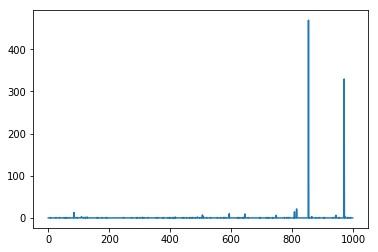

In [54]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [55]:
entropy(values)

tensor(2.7056)

In [ ]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist, tk = diversity(learn, 10, 95)
n, hist, tk

at batch no 0
at batch no 100


In [ ]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [ ]:
entropy(values)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)